In [1]:
%matplotlib notebook

import tensorflow as tf
from tensorflow import keras

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
n = 64
batch_size = 100

# Set up model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(n,n,2)),
    keras.layers.Dense(2*(n**2), activation=tf.nn.tanh),
    keras.layers.Dense(n**2, activation=tf.nn.tanh),
    keras.layers.Dense(n**2),
    keras.layers.Reshape((n,n,1)),
    keras.layers.Conv2D(64, (5,5), strides=(1,1), activation=tf.nn.relu, padding='same'),
    keras.layers.Conv2D(64, (5,5), strides=(1,1), activation=tf.nn.relu, padding='same'),
    keras.layers.Conv2DTranspose(1, (7,7), strides=(1,1), data_format='channels_last', padding='same')
    ])
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00002,rho=0.9),
        loss='mean_squared_error',
        metrics=[keras.metrics.mae])

# Load trained model weights
model.load_weights('training/automap64/cp-0200.ckpt')

In [3]:
def idftmtx(N):
    return sp.ifft(sp.eye(N))

In [4]:
# Put single img_array into (batch_size,width,height,num_channels) format:
def batch_img(img_array):
    return np.expand_dims(np.expand_dims(img_array,0),-1)

# Generate k-space network input
def get_fft(img_array):
    img_fft = np.fft.fft2(img_array)
    img_fft_re = np.real(img_fft)
    img_fft_im = np.imag(img_fft)
    return np.concatenate([img_fft_re,img_fft_im],axis=3)

<IPython.core.display.Javascript object>


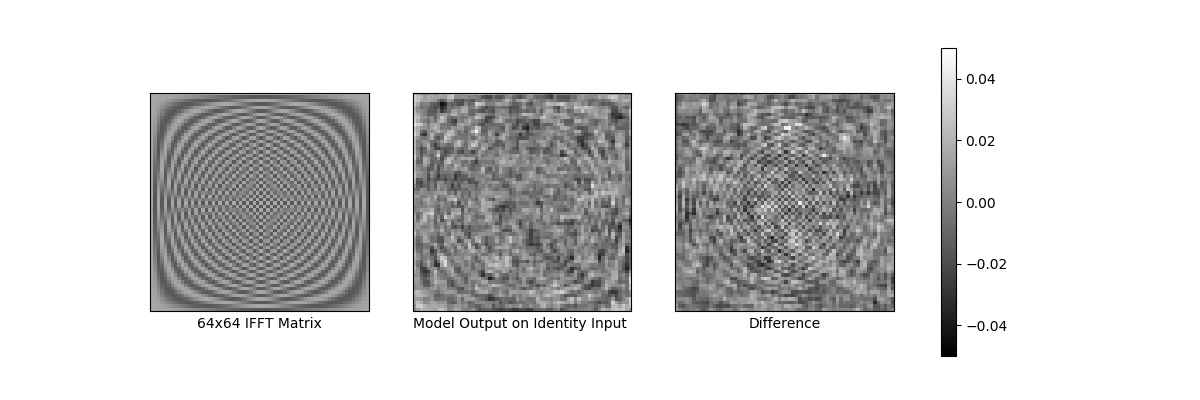

In [6]:
fig,axes = plt.subplots( 1,3, figsize=[12,4] )
for i,iax in enumerate(axes.flatten()):
    if i==0:
        true_ifft = np.real(idftmtx(64))
        im = iax.imshow(true_ifft,cmap='gray',vmin=-0.05,vmax=0.05)
        iax.set_yticks([])
        iax.set_xticks([])
        iax.set_xlabel('64x64 IFFT Matrix')
    elif i==1:
        identity = np.eye(64)
        identity_input = np.concatenate((batch_img(identity),batch_img(np.zeros((64,64)))),axis=3)
        identity_recon = model.predict(identity_input)[0,:,:,0]
        im = iax.imshow(identity_recon,cmap='gray',vmin=-0.05,vmax=0.05)
        iax.set_yticks([])
        iax.set_xticks([])
        iax.set_xlabel('Model Output on Identity Input ')
    elif i==2:
        im = iax.imshow(true_ifft-identity_recon,cmap='gray',vmin=-0.05,vmax=0.05)
        iax.set_yticks([])
        iax.set_xticks([])
        iax.set_xlabel('Difference',)
        
fig.colorbar(im, ax=axes.ravel().tolist())